# **Khởi tạo**

**Import thư viện**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Dropout, LSTM, Dense, Flatten, Reshape
import os

**Đọc và xử lý dữ liệu**

In [2]:
def read_file(file_name):
    # Đọc dữ liệu từ file CSV
    data = pd.read_csv(file_name)

    # Chuyển cột 'Date' thành kiểu dữ liệu datetime và đặt làm index
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

    # Chuyển đổi các cột khác sang dạng số nếu cần thiết
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    data = data[['Price']]

    # Sắp xếp dữ liệu theo thời gian từ quá khứ đến hiện tại
    data.sort_index(inplace=True)
    data = data.reset_index()['Price']

    return data

**Xây dựng mô hình**

In [3]:
# Hàm tính MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [4]:
# Hàm Create Dataset
def create_dataset(dataset, seq_size=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-seq_size-1):
        window = dataset[i:(i+seq_size), 0]
        dataX.append(window)
        dataY.append(dataset[i + seq_size, 0])
    return np.array(dataX), np.array(dataY)

In [5]:
def LSTM_prediction(name, data, train_ratio=0.7, days=30):

    # Chuẩn hóa dữ liệu
    scaler = MinMaxScaler(feature_range=(0,1))
    data = scaler.fit_transform(np.array(data).reshape(-1,1))

    # Chia train, test
    train_size = int(train_ratio * len(data))
    test_size = len(data) - train_size
    train_data = data[:train_size]
    test_data = data[train_size:]
    
    # Reshape into X=t,t+1,t+2..t+99 and Y=t+100
    seq_size = 100
    X_train, y_train = create_dataset(train_data, seq_size)
    X_test, y_test = create_dataset(test_data, seq_size)
    
    # Reshape input to be [samples, time steps, features] which is required for LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
  
    # Xây dựng mô hình LSTM
    model=Sequential()
    model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
    model.add(LSTM(50,return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam')
    # model.summary()
    
    # Fit mô hình với dữ liệu train
    model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)

    # Dự báo dữ liệu test
    train_predict = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    # Chuẩn hóa dữ liệu y_pred
    train_predict=scaler.inverse_transform(train_predict)
    y_pred=scaler.inverse_transform(y_pred)
    # Chuẩn hóa dữ liệu y_test
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Đánh giá độ chính xác thuật toán bằng RMSE
    test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
    print('Testing RMSE:', test_rmse)

    # Đánh giá độ chính xác thuật toán bằng MAE
    test_mae = mean_absolute_error(y_test, y_pred)
    print('Testing MAE:', test_mae)
    
    # Đánh giá độ chính xác thuật toán bằng MAPE
    test_mape = mean_absolute_percentage_error(y_test, y_pred)
    print('Testing MAPE:', test_mape)

    # Dự báo các ngày tiếp theo
    x_input = test_data[-seq_size:].reshape(1, -1)
    temp_input = list(x_input[0])
    lst_output = []

    while len(lst_output) < days:
        if len(temp_input) > seq_size:
            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape(1, -1)
            x_input = x_input.reshape((1, seq_size, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
        else:
            x_input = x_input.reshape((1, seq_size, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
    
    # Vẽ hình
    plt.figure(figsize=(10, 6))
    plt.title('LSTM {} ({})'.format(train_ratio, name))
    plt.plot(scaler.inverse_transform(train_data))
    test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
    plt.plot(test_data_index,scaler.inverse_transform(test_data))
    test_data_index = pd.RangeIndex(start=train_size+seq_size+1, stop=train_size+test_size, step=1)
    plt.plot(test_data_index,(y_pred))
    prediect_data_index = pd.RangeIndex(start=len(data)-1, stop=len(data)+days-1, step=1)
    plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
    plt.legend(['Train','Test','Predict','Predict'+str(days)+'days'])
    plt.show()
    

# **BIDV**

In [6]:
data = read_file("../Dataset/BID Historical Data.csv")
name = 'BIDV'

## **30 ngày**

**BIDV 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Testing RMSE: 971.821125693277
Testing MAE: 750.96410732582
Testing MAPE: 1.764361435347169


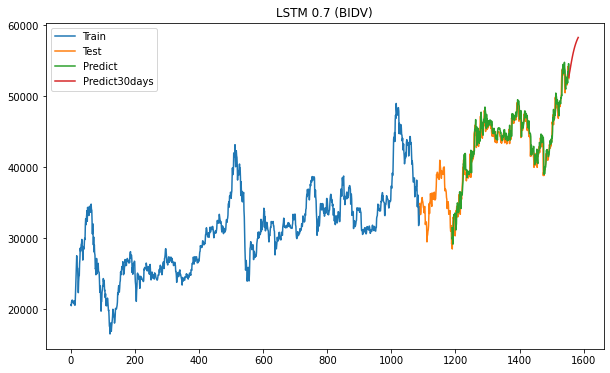

In [7]:
LSTM_prediction(name, data, 0.7)

**BIDV 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Testing RMSE: 956.0169409790537
Testing MAE: 710.2596354166668
Testing MAPE: 1.5500664791625478


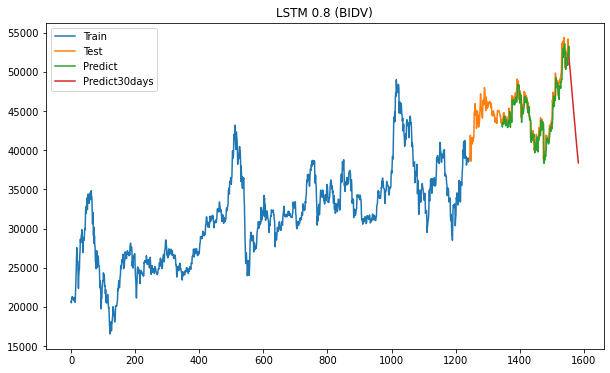

In [8]:
LSTM_prediction(name, data, 0.8)

**BIDV 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Testing RMSE: 908.0619090286897
Testing MAE: 695.193821022727
Testing MAPE: 1.3869681700726835


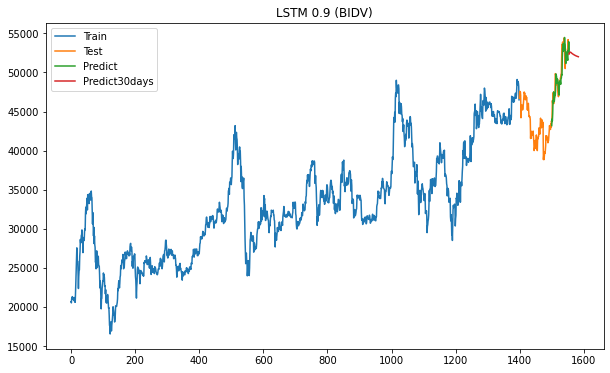

In [9]:
LSTM_prediction(name, data, 0.9)

## **60 ngày**

**BIDV 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Testing RMSE: 899.3264005425681
Testing MAE: 661.4951331967214
Testing MAPE: 1.5541165299315742


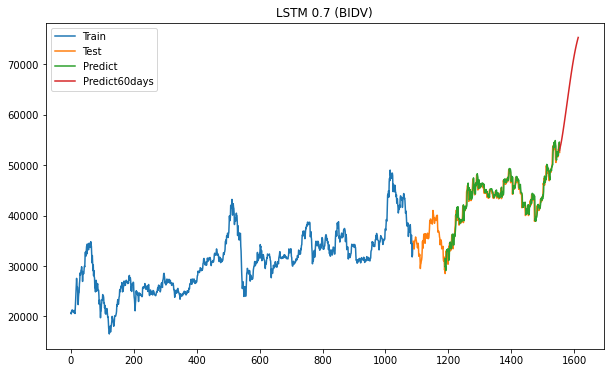

In [10]:
LSTM_prediction(name, data, 0.7, 60)

**BIDV 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Testing RMSE: 1182.7037429685959
Testing MAE: 967.3274367559527
Testing MAPE: 2.1091444962004653


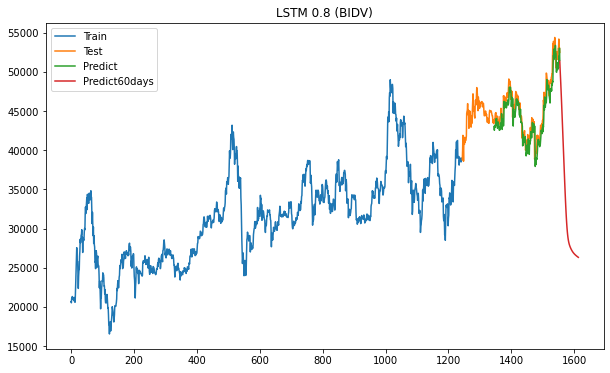

In [11]:
LSTM_prediction(name, data, 0.8, 60)

**BIDV 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Testing RMSE: 914.0085489034522
Testing MAE: 687.4561079545452
Testing MAPE: 1.372911015679443


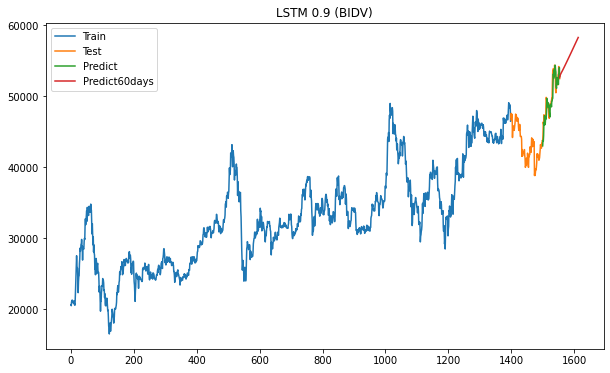

In [12]:
LSTM_prediction(name, data, 0.9, 60)

## **90 ngày**

**BIDV 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Testing RMSE: 931.9854092323432
Testing MAE: 672.0693306010929
Testing MAPE: 1.5739397635486505


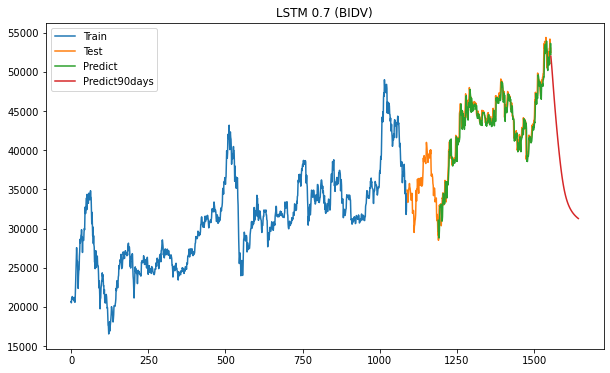

In [13]:
LSTM_prediction(name, data, 0.7, 90)

**BIDV 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Testing RMSE: 831.2265169548187
Testing MAE: 589.0154017857144
Testing MAPE: 1.2947893451443873


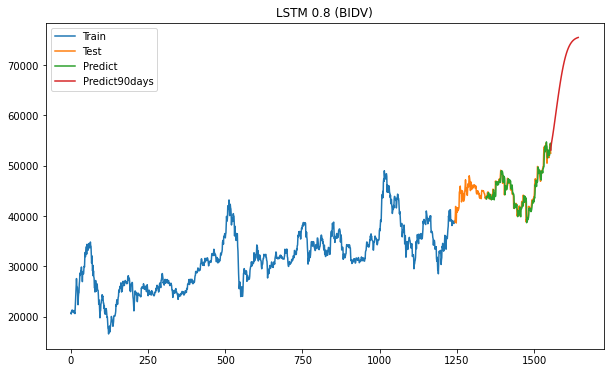

In [14]:
LSTM_prediction(name, data, 0.8, 90)

**BIDV 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Testing RMSE: 924.7485608104761
Testing MAE: 697.7537642045452
Testing MAPE: 1.394269069073628


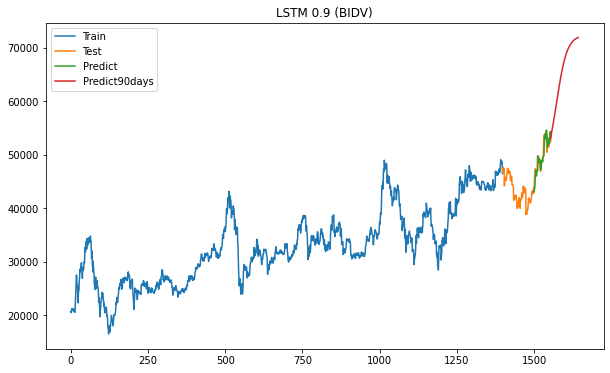

In [15]:
LSTM_prediction(name, data, 0.9, 90)

# **VCB**

In [16]:
data = read_file("../Dataset/VCB Historical Data.csv");
name = 'VCB'

## **30 ngày**

**VCB 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Testing RMSE: 2432.3598834335626
Testing MAE: 1958.0671213285514
Testing MAPE: 2.1860920886287114


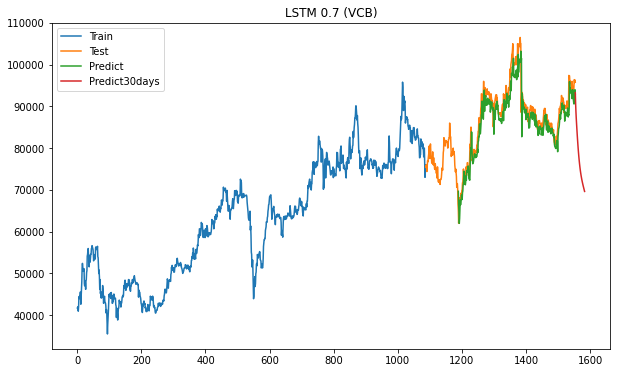

In [17]:
LSTM_prediction(name, data, 0.7)

**VCB 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Testing RMSE: 1723.6131270548105
Testing MAE: 1070.5379836309526
Testing MAPE: 1.170178659962461


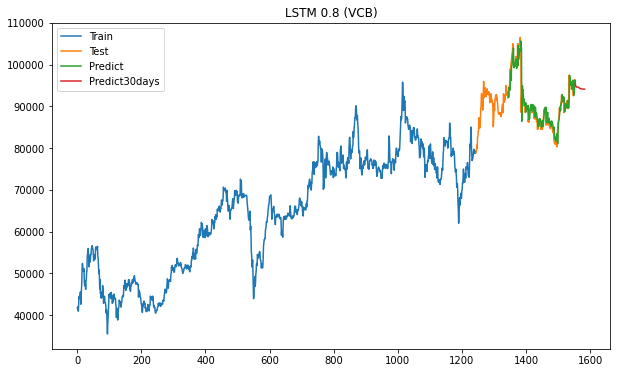

In [18]:
LSTM_prediction(name, data, 0.8)

**VCB 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Testing RMSE: 2244.6482724837297
Testing MAE: 1833.602130681817
Testing MAPE: 1.9942312493894376


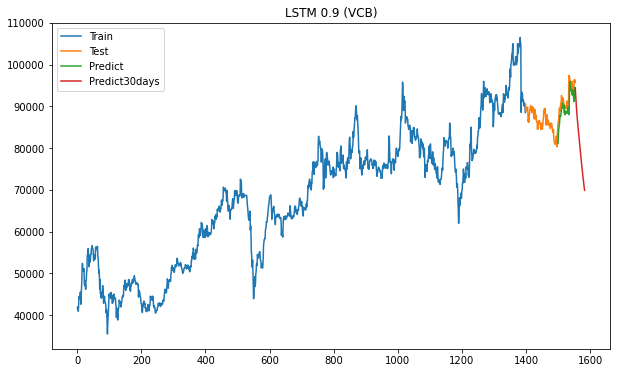

In [19]:
LSTM_prediction(name, data, 0.9)

## **60 ngày**

**VCB 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Testing RMSE: 1787.4550181273669
Testing MAE: 1268.083386697405
Testing MAPE: 1.4733618992704391


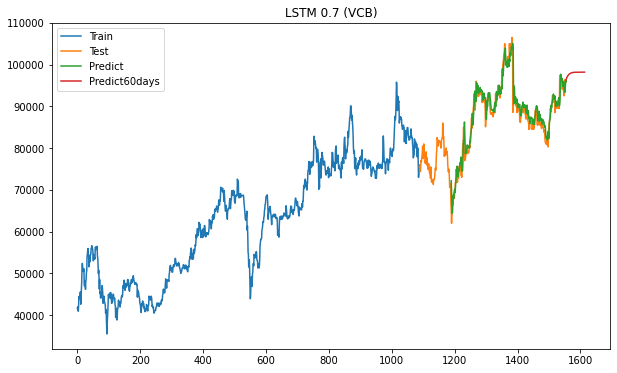

In [20]:
LSTM_prediction(name, data, 0.7, 60)

**VCB 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Testing RMSE: 1762.881171706796
Testing MAE: 1081.07890625
Testing MAPE: 1.1697827713596223


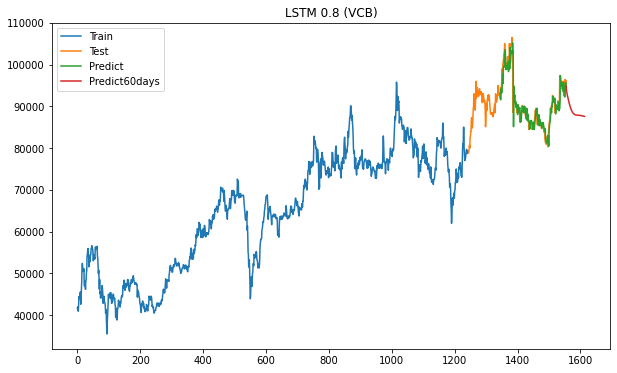

In [21]:
LSTM_prediction(name, data, 0.8, 60)

**VCB 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Testing RMSE: 1331.1712155038579
Testing MAE: 996.0089488636364
Testing MAPE: 1.0801403136044876


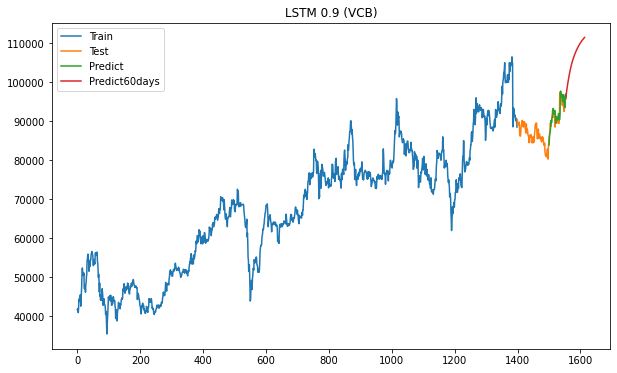

In [22]:
LSTM_prediction(name, data, 0.9, 60)

## **90 ngày**

**VCB 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Testing RMSE: 2474.7991404708578
Testing MAE: 1984.0611765710375
Testing MAPE: 2.2298517248158434


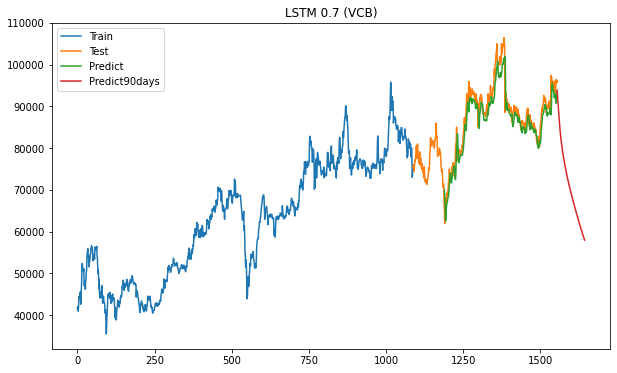

In [23]:
LSTM_prediction(name, data, 0.7, 90)

**VCB 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Testing RMSE: 1715.899941617087
Testing MAE: 1102.7073288690478
Testing MAPE: 1.216098989352749


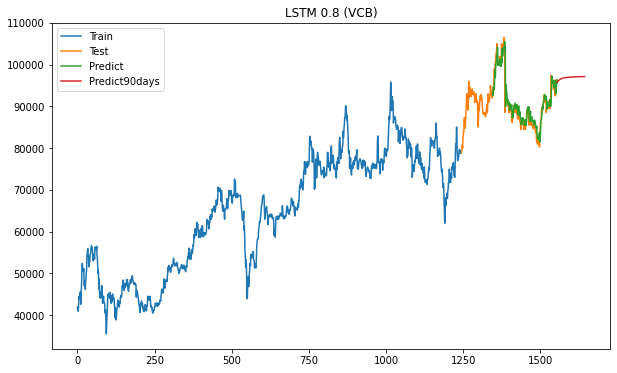

In [24]:
LSTM_prediction(name, data, 0.8, 90)

**VCB 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Testing RMSE: 1624.3969879399822
Testing MAE: 1210.9859374999994
Testing MAPE: 1.3148191370828628


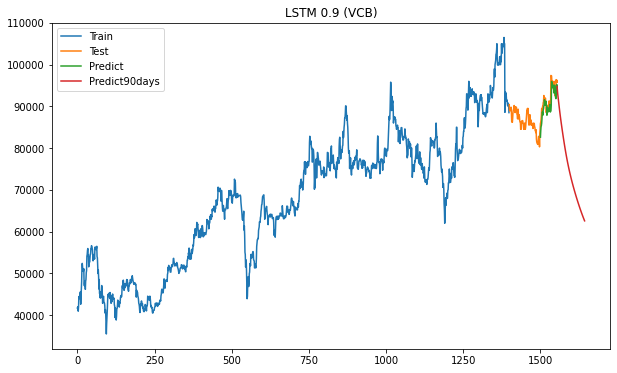

In [25]:
LSTM_prediction(name, data, 0.9, 90)

# **MBB**

In [26]:
data = read_file("../Dataset/MBB Historical Data.csv");
name = 'MBB'

## **30 ngày**

**MBB 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Testing RMSE: 545.563762942561
Testing MAE: 387.36778197575137
Testing MAPE: 2.0651646269394033


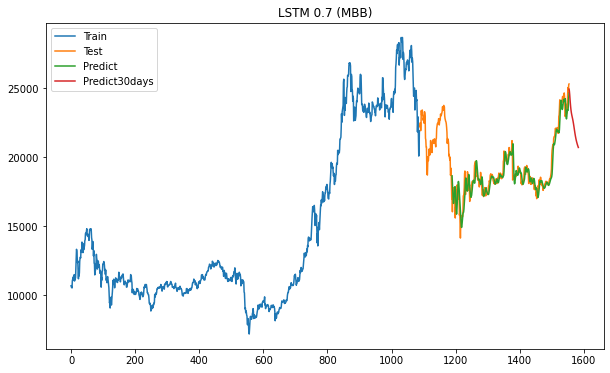

In [27]:
LSTM_prediction(name, data, 0.7)

**MBB 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Testing RMSE: 418.266713011806
Testing MAE: 283.279040178572
Testing MAPE: 1.429157358416914


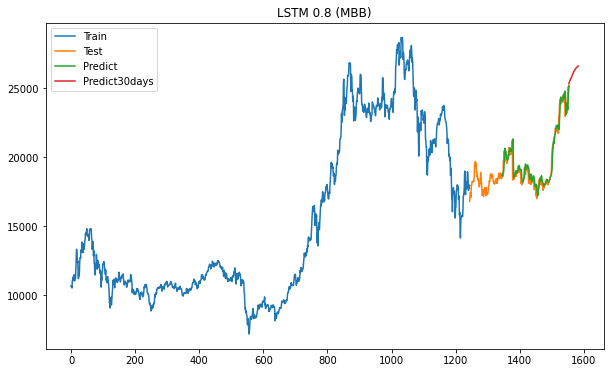

In [28]:
LSTM_prediction(name, data, 0.8)

**MBB 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Testing RMSE: 478.68100093666044
Testing MAE: 376.2111860795454
Testing MAPE: 1.6506438311308116


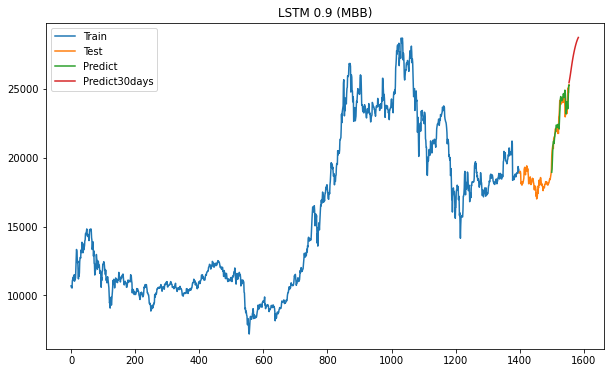

In [29]:
LSTM_prediction(name, data, 0.9)

## **60 ngày**

**MBB 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Testing RMSE: 523.4961700502363
Testing MAE: 389.0521014771181
Testing MAPE: 2.105901938464162


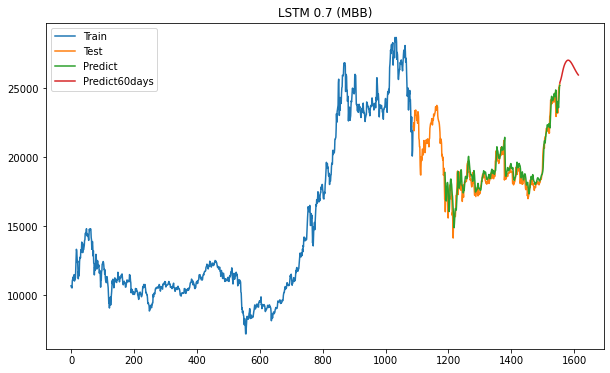

In [30]:
LSTM_prediction(name, data, 0.7, 60)

**MBB 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Testing RMSE: 566.4698313574077
Testing MAE: 452.4676283482151
Testing MAPE: 2.303258714858313


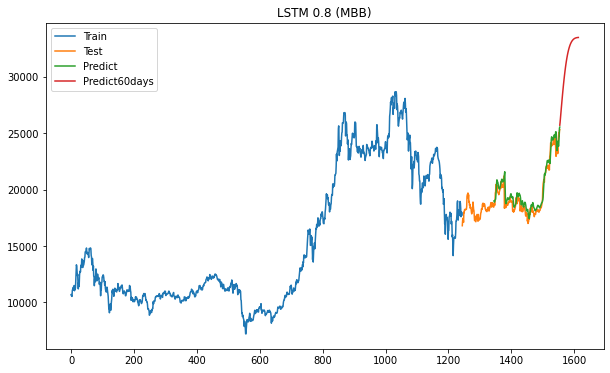

In [31]:
LSTM_prediction(name, data, 0.8, 60)

**MBB 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Testing RMSE: 787.7602533985867
Testing MAE: 677.2027698863633
Testing MAPE: 2.9606206730821416


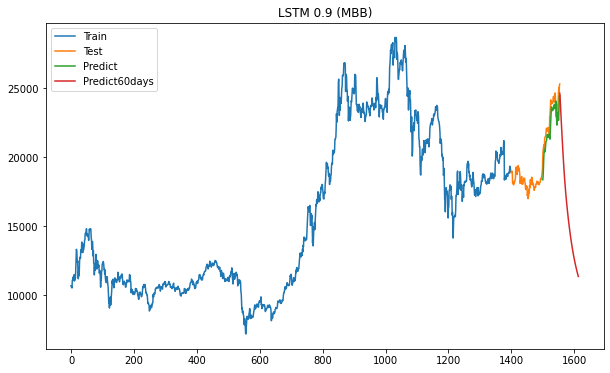

In [32]:
LSTM_prediction(name, data, 0.9, 60)

## **90 ngày**

**MBB 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Testing RMSE: 623.4033622262126
Testing MAE: 489.38212090164
Testing MAPE: 2.630165306460517


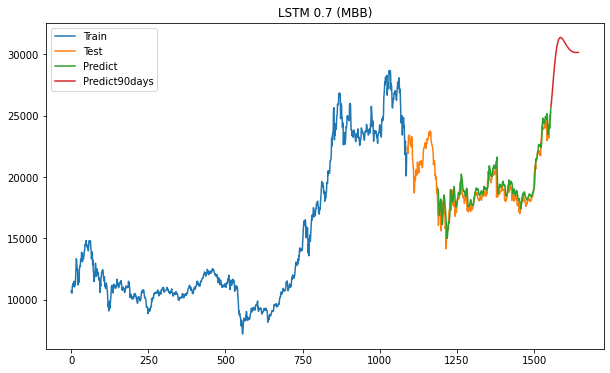

In [33]:
LSTM_prediction(name, data, 0.7, 90)

**MBB 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Testing RMSE: 382.4279786585088
Testing MAE: 244.84593005952414
Testing MAPE: 1.226448357765307


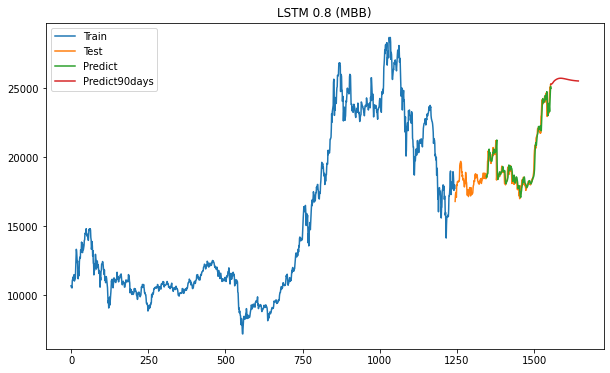

In [34]:
LSTM_prediction(name, data, 0.8, 90)

**MBB 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Testing RMSE: 410.388389317807
Testing MAE: 302.36562499999985
Testing MAPE: 1.3217819797100054


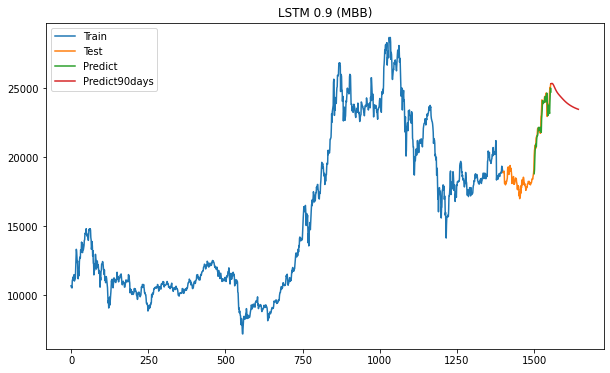

In [35]:
LSTM_prediction(name, data, 0.9, 90)